In [1]:
import os 
import pandas as pd

In [2]:
# Path to the root folder by going up two levels from the current directory
root_folder = os.path.join('..', 'Datasets')

# Path to file.csv within the datasets folder under the root folder
csv_file_path = os.path.join(root_folder, 'airline-passengers.csv')

# Repeat cleaning steps from last notebook
df = pd.read_csv(csv_file_path)

# Rename columns
df.rename({'Month':'Date', '#Passengers':'Passengers'}, axis=1, inplace=True)

df['Date'] = pd.to_datetime(df.Date)
df.set_index('Date', inplace=True)
df.head()

,Passengers
Date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [3]:
# Autocorrelation is the correlation of a time series with itself.
# There are multiple ways to calculate autocorrelation in Python and many slight variants of this measure as well. 
# Since there are many ways to get an answer, it helps to have a firm understanding of the underlying concepts 

# Way1:
# Compute autocorrelation from scratch

# lets create shifted3 column, that shifts the passenges column 3months in the future 
df['shifted3'] = df.Passengers.shift(-3)
df.head()

,Passengers,shifted3
Date,,
1949-01-01,112,129.0
1949-02-01,118,121.0
1949-03-01,132,135.0
1949-04-01,129,148.0
1949-05-01,121,148.0


In [4]:
#  Let's compute the correlation matrix of DF. This tells us that the lag 3 autocorrelation is around 0.84. 
df.corr()

,Passengers,shifted3
Passengers,1.000000,0.837395
shifted3,0.837395,1.000000


In [5]:
# Let's get the lag 12 autocorrelation in the same way
df['shifted12'] = df.Passengers.shift(-12)
df.head()

,Passengers,shifted3,shifted12
Date,,,
1949-01-01,112,129.0,115.0
1949-02-01,118,121.0,126.0
1949-03-01,132,135.0,141.0
1949-04-01,129,148.0,135.0
1949-05-01,121,148.0,125.0


In [6]:
df.corr()

,Passengers,shifted3,shifted12
Passengers,1.000000,0.837395,0.990527
shifted3,0.837395,1.000000,0.819794
shifted12,0.990527,0.819794,1.000000


In [7]:
# We can simplify the view by pulling out the passengers column from the correlation DataFrame. 
# We see that the lag 12 autocorrelation is higher, it's around 0.99. 
# That gives us a clue that the yearly pattern might be stronger than the three month or quarterly pattern.
df.corr().Passengers

Passengers    1.000000
shifted3      0.837395
shifted12     0.990527
Name: Passengers, dtype: float64

In [8]:
# Similarly, lets poll the lag 24 correlation
# This will compare the 10-year period starting with 1949 to the ten-year period starting with 1951. 
# We see here that the lag 24 auto-correlation is also strong
df['shifted24'] = df.Passengers.shift(-24)
df.head()

,Passengers,shifted3,shifted12,shifted24
Date,,,,
1949-01-01,112,129.0,115.0,145.0
1949-02-01,118,121.0,126.0,150.0
1949-03-01,132,135.0,141.0,178.0
1949-04-01,129,148.0,135.0,163.0
1949-05-01,121,148.0,125.0,172.0


In [9]:
df.corr().Passengers

Passengers    1.000000
shifted3      0.837395
shifted12     0.990527
shifted24     0.983254
Name: Passengers, dtype: float64

In [10]:
# There is a simpler way to get autocorrelations with pandas 
# Way 2 
# Use the autocorr method and pass in the lag 
df.Passengers.autocorr(-3)

0.837394765081794

In [11]:
df.Passengers.autocorr(-12)

0.990527369208544

In [12]:
df.Passengers.autocorr(-24)

0.9832540581084245

## Plot all atocorrelations as a function of lag

<Axes: >

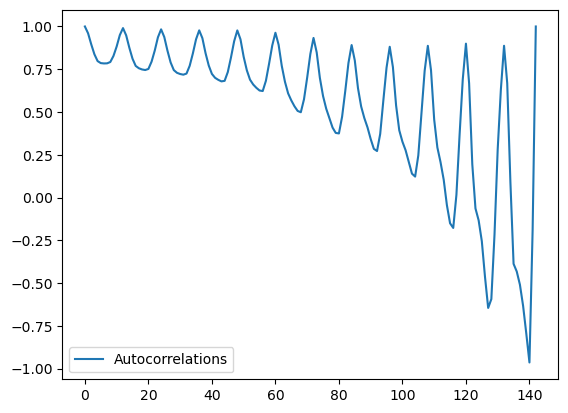

In [13]:
# Create a dataframe with a column `Autocorrelations`
acs = pd.DataFrame({'Autocorrelations': [df.Passengers.autocorr(n) for n in range(143)]})

# Let's plot acs. We see a plot of all the auto correlations of various lags. 
# We noticed that the peaks happen every 12 months. 
# In other words, the series is most correlated to itself when it's translated 12 months, 24 months, etc
# This is strong evidence of a yearly pattern. We can make this look cleaner by changing the v lines method to plot. 
# We supply a list-like object of X values for the vertical lines, we use the range function 
# to indicate the multiples of 12 up to 142 for the vertical lines.
acs.plot()

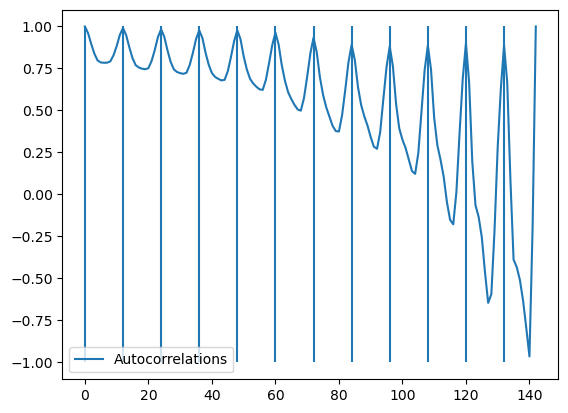

In [14]:
# This can be clear by using the vlines method 
x = range(0, 143, 12) # list of lags [12, 24, 36, ..., 142]
acs.plot().vlines(x, -1, 1)

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

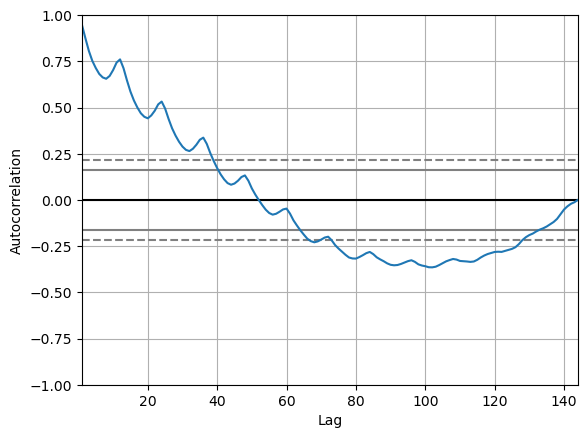

In [15]:
# Another way to plot autocorrelations 
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(df['Passengers'])

In [16]:
#  Why does it look different?
# finding the correlation involves subtracting their means, or de-meaning 
# Correlation asks: How is series A being above/below it mean
# related to series B being above/below its mean?

# In our original graph - the de-meaning was done individually for every lagged series. 
# on the otherhand, the pandas plot autocorrelation function out of the box, 
# the overall searies mean is subtracted from each lagged series 

# Let's say time series 1 is the two-year period starting with 1949, and time series 2 is the two-year period starting with 1959. 
# The lag between them would be 10 years or 120 months. 
# The overall mean would just be the mean of the passengers column. 
overall_mean = df.Passengers.mean()

# To find the mean of series 1, we only want to take certain rows. 
# Since the date is the index, we'll filter by the condition that the index is less than January 1st 1951. 
# This will account for the years 1949 and 1950. Then, we'll pull the passengers column and take the mean. 
mean1 = df[df.Passengers.index < pd.to_datetime('1-1-1951')].Passengers.mean()

# For the mean of series 2, we'll use similar logic, but only include dates greater than December 1st 1958. 
# This will account for the years 1959 and 1960. We'll set this to mean 2. Then we'll print the three means. 
mean2 = df[df.Passengers.index > pd.to_datetime('12-1-1958')].Passengers.mean()

# We see that the overall mean is 280, and that the means in series 1 and 2 are much lower and much higher than this respectively. 
print(f'overall_mean: {overall_mean}\nmean1: {mean1}\nmean2: {mean2}')

# overall_mean: 280.2986111111111
# mean1: 133.16666666666666
# mean2: 452.25

# The pandas autocorrelation plot uses the mean of 280 for both series. 
# Since all numbers in series one are below this mean, and all numbers in series 2 are above this mean, 
# this falsely tells the story that these two series have a negative correlation. 
# On the other hand, in our methodology, 133 was used to de-mean the first series, and 452 was used to de-mean the second series, 
# which lead to a positive correlation. 
# This brings up a key point. A stationary series is one for which the mean, the variance, and other descriptive 
# statistics don't vary over time. 
# There are various types of stationarity for which there are precise definitions, but we'll keep it simple for now.
# We'll think of a stationary time series as having three simple properties. 
# Constant mean over time, constant variance over time, and no seasonality. 
# The reason that the pandas autocorrelation plot gives us a weird look is because the mean in our time series isn't constant over time.

overall_mean: 280.2986111111111
mean1: 133.16666666666666
mean2: 452.25


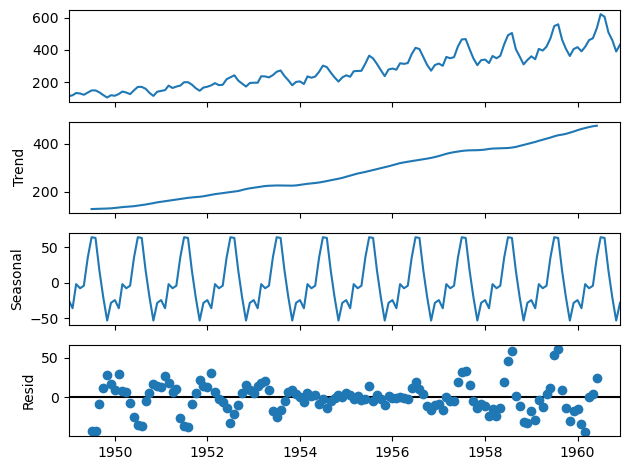

In [17]:
# Let's revisit the seasonal decompose function to try to understand stationarity a bit better. 
from statsmodels.tsa.seasonal import seasonal_decompose

# Let's apply it once more to our DataFrame with only the passengers column.
decomp = seasonal_decompose(df[['Passengers']])

# We use decomps plot method and we revisit this components look from the last notebook. We see that the passengers time series is not stationary. 
decomp.plot();

- Its mean and variance both increase over time. 
- The mean of the trend time series also increases over time, even though it's variance is roughly constant. 
- The trend time series is not stationary either. 
- The seasonal time series is not stationary because it has seasonality. 
- The residuals time series isn't supposed to have any pattern. We see that its mean is roughly constant near zero. However, we notice that the variance is higher near the beginning and the end of the time series, than it is near the center. This time series is not stationary.

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

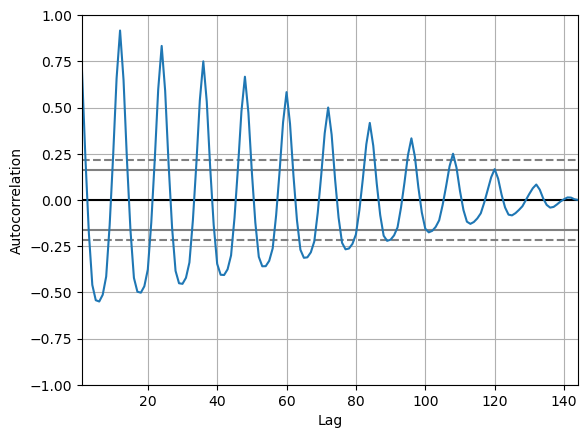

In [18]:
# Let's apply the pandas autocorrelation plot to just the seasonal time series. 
autocorrelation_plot(decomp.seasonal)

This is a much nicer look. We see that the autocorrelations are no longer negative for any lags that are multiples of 12. Instead, these correlations just get weaker over time, largely due to the fact that the time series being compared grows shorter. In the next video, we'll learn about partial autocorrelation